## Query 1
Να ταξινομημηθούν, σε φθίνουσα σειρά, οι ηλικιακές ομάδες των θυμάτων σε περιστατικά που περιλαμβάνουν οποιαδήποτε μορφή “βαριάς σωματικής βλάβης”. Θεωρείστε τις εξής ηλικιακές ομάδες:

- Παιδιά: < 18 
- Νεαροί ενήλικοι: 18 – 24
- Ενήλικοι: 25 – 64 
- Ηλικιωμένοι: >64

Να υλοποιηθεί το Query 1 χρησιμοποιώντας τα DataFrame και RDD APIs. Να εκτελέσετε και
τις δύο υλοποιήσεις με 4 Spark executors. Υπάρχει διαφορά στην επίδοση μεταξύ των δύο APIs;
Αιτιολογήσετε την απάντησή σας. (20%)


In [1]:
%%configure -f
{
    "conf": {
        "spark.executor.instances": "4",
        "spark.executor.memory": "8g",
        "spark.executor.cores": "1",
        "spark.driver.memory": "2g"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3839,application_1732639283265_3779,pyspark,idle,Link,Link,None,
3843,application_1732639283265_3783,pyspark,idle,Link,Link,None,
3875,application_1732639283265_3815,pyspark,idle,Link,Link,None,
3882,application_1732639283265_3822,pyspark,idle,Link,Link,None,
3883,application_1732639283265_3823,pyspark,idle,Link,Link,None,
3887,application_1732639283265_3827,pyspark,idle,Link,Link,None,
3897,application_1732639283265_3837,pyspark,idle,Link,Link,None,
3959,application_1732639283265_3899,pyspark,idle,Link,Link,None,
3979,application_1732639283265_3919,pyspark,idle,Link,Link,None,
4029,application_1732639283265_3969,pyspark,idle,Link,Link,None,


In [2]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 1 execution") \
    .getOrCreate()

# Access configuration
conf = spark.sparkContext.getConf()

# Print relevant executor settings
print("Executor Instances:", conf.get("spark.executor.instances"))
print("Executor Cores:", conf.get("spark.executor.cores"))
print("Executor Memory:", conf.get("spark.executor.memory"))


Starting Spark application


KeyboardInterrupt: 

In [ ]:
from pyspark.sql import SparkSession
import csv
import time

# Create Spark session
sc = SparkSession \
    .builder \
    .appName("Query 1 execution") \
    .getOrCreate() \
    .sparkContext

start_time = time.time()

# Read the CSV files from S3 into RDDs
rdd1 = sc.textFile("s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2010_to_2019_20241101.csv")
rdd2 = sc.textFile("s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2020_to_Present_20241101.csv")

# Combine the RDDs
data_rdd = rdd1.union(rdd2)

# Split each line into columns (cannot use split(",") because certain fields contain commas)
columns_rdd = data_rdd.map(lambda line: next(csv.reader([line])))

# Filter records with "Aggravated Assault" in 'Crm Cd Desc'
aggr_assault_rdd = columns_rdd.filter(lambda row: 'AGGRAVATED ASSAULT' in row[9])

# Map data into age groups
age_groups_rdd = aggr_assault_rdd.map(lambda row: int(row[11])) \
    .map(lambda age: (
        'Children (<18)' if age < 18 else
        'Young Adults (18-24)' if age <= 24 else
        'Adults (25-64)' if age <= 64 else
        'Elderly (>64)', 1))

# Reduce by key to count occurrences
age_group_counts = age_groups_rdd.reduceByKey(lambda a, b: a + b)

# Sort by count in descending order
sorted_age_groups = age_group_counts.sortBy(lambda x: -x[1])

print(sorted_age_groups.take(5))

# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"[RDD API] Time taken: {elapsed_time:.2f} seconds")

### Implementation using Dataframes 


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, when, count
import time

# Create Spark session
spark = SparkSession \
    .builder \
    .appName("Query 1 execution") \
    .getOrCreate()

start_time = time.time()

# Define schema for Crime Data
crime_data_schema = StructType([
    StructField("DR_NO", StringType(), True),
    StructField("Date Rptd", StringType(), True),
    StructField("DATE OCC", StringType(), True),
    StructField("TIME OCC", StringType(), True),
    StructField("AREA", StringType(), True),
    StructField("AREA NAME", StringType(), True),
    StructField("Rpt Dist No", StringType(), True),
    StructField("Part 1-2", StringType(), True),
    StructField("Crm Cd", StringType(), True),
    StructField("Crm Cd Desc", StringType(), True),
    StructField("Mocodes", StringType(), True),
    StructField("Vict Age", StringType(), True),
    StructField("Vict Sex", StringType(), True),
    StructField("Vict Descent", StringType(), True),
    StructField("Premis Cd", StringType(), True),
    StructField("Premis Desc", StringType(), True),
    StructField("Weapon Used Cd", StringType(), True),
    StructField("Weapon Desc", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Status Desc", StringType(), True),
    StructField("Crm Cd 1", StringType(), True),
    StructField("Crm Cd 2", StringType(), True),
    StructField("Crm Cd 3", StringType(), True),
    StructField("Crm Cd 4", StringType(), True),
    StructField("LOCATION", StringType(), True),
    StructField("Cross Street", StringType(), True),
    StructField("LAT", StringType(), True),
    StructField("LON", StringType(), True)
])

# Read the CSV files from S3 into DataFrames
file1 = "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2010_to_2019_20241101.csv"
file2 = "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2020_to_Present_20241101.csv"

df1 = spark.read.csv(file1, header=True, schema=crime_data_schema)
df2 = spark.read.csv(file2, header=True, schema=crime_data_schema)

# Combine both DataFrames
df = df1.union(df2)

# Filter for aggravated assault in 'Crm Cd Desc'
aggravated_assault_df = df.filter(col("Crm Cd Desc").contains("AGGRAVATED ASSAULT")) \
                .select( col("DR_NO"), col("Vict Age"))

# Create age groups
age_grouped_df = aggravated_assault_df.withColumn(
    "Age Group",
    when(col("Vict Age") < 18, "Children")
    .when((col("Vict Age") >= 18) & (col("Vict Age") <= 24), "Young Adults")
    .when((col("Vict Age") >= 25) & (col("Vict Age") <= 64), "Adults")
    .when(col("Vict Age") > 64, "Elderly")
    .otherwise("Unknown")
)

# Count occurrences by age group
age_group_count = age_grouped_df.groupBy("Age Group").agg(count("DR_NO").alias("Count"))

# Sort results in descending order
sorted_age_groups = age_group_count.orderBy(col("Count").desc())

# Show results
sorted_age_groups.show()


# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"[Dataframe API] Time taken: {elapsed_time:.2f} seconds")

## Query 2 
Να βρεθούν, για κάθε έτος, τα 3 Αστυνομικά Τμήματα με το υψηλότερο ποσοστό κλεισμένων (περατωμένων) υποθέσεων. Να τυπωθούν το έτος, τα ονόματα (τοποθεσίες) των τμημάτων, τα ποσοστά τους καθώς και οι αριθμοί του ranking τους στην ετήσια κατάταξη. Τα αποτελέσματα να δοθούν σε σειρά αύξουσα ως προς το έτος και το ranking (δείτε παράδειγμα στον Πίνακα 2).

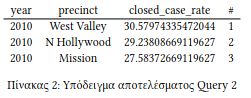

α) Να υλοποιηθεί το Query 2 χρησιμοποιώντας τα DataFrame και SQL APIs. Να αναφέρετε και
να συγκρίνετε τους χρόνους εκτέλεσης μεταξύ των δύο υλοποιήσεων. (10%)

In [ ]:
%%configure -f
{
    "conf": {
        "spark.executor.instances": "1",
        "spark.executor.memory": "8g",
        "spark.executor.cores": "1",
        "spark.driver.memory": "2g"
    }
}

In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 2 execution") \
    .getOrCreate()

# Access configuration
conf = spark.sparkContext.getConf()

# Print relevant executor settings
print("Executor Instances:", conf.get("spark.executor.instances"))
print("Executor Cores:", conf.get("spark.executor.cores"))
print("Executor Memory:", conf.get("spark.executor.memory"))


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 2 execution") \
    .getOrCreate()

start_time = time.time()

# Define schema for Crime Data
crime_data_schema = StructType([
    StructField("DR_NO", StringType(), True),
    StructField("Date Rptd", StringType(), True),
    StructField("DATE OCC", StringType(), True),
    StructField("TIME OCC", StringType(), True),
    StructField("AREA", StringType(), True),
    StructField("AREA NAME", StringType(), True),
    StructField("Rpt Dist No", StringType(), True),
    StructField("Part 1-2", StringType(), True),
    StructField("Crm Cd", StringType(), True),
    StructField("Crm Cd Desc", StringType(), True),
    StructField("Mocodes", StringType(), True),
    StructField("Vict Age", StringType(), True),
    StructField("Vict Sex", StringType(), True),
    StructField("Vict Descent", StringType(), True),
    StructField("Premis Cd", StringType(), True),
    StructField("Premis Desc", StringType(), True),
    StructField("Weapon Used Cd", StringType(), True),
    StructField("Weapon Desc", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Status Desc", StringType(), True),
    StructField("Crm Cd 1", StringType(), True),
    StructField("Crm Cd 2", StringType(), True),
    StructField("Crm Cd 3", StringType(), True),
    StructField("Crm Cd 4", StringType(), True),
    StructField("LOCATION", StringType(), True),
    StructField("Cross Street", StringType(), True),
    StructField("LAT", StringType(), True),
    StructField("LON", StringType(), True)
])

# Read Crime Data from S3
crime_data_2010_2019 = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2010_to_2019_20241101.csv", 
    header=True, schema=crime_data_schema)

crime_data_2020_present = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2020_to_Present_20241101.csv", 
    header=True, schema=crime_data_schema)

# Union the Crime Data
crime_data = crime_data_2010_2019.union(crime_data_2020_present)

# Read Police Stations data from S3
police_stations = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/LA_Police_Stations.csv", 
    header=True, inferSchema=True)

# Prepare Crime Data
crime_data = crime_data.withColumn("Year", year(to_date(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a")))
crime_data = crime_data.withColumnRenamed("AREA ", "AREA") 


# Calculate the total number of cases per year and station
total_cases_per_year_station = crime_data.groupBy("Year", "AREA NAME").agg(
    count("DR_NO").alias("total_Cases"),
    sum(when((col("Status") != "IC") & (col("Status") != "UNK"), 1).otherwise(0)).alias("Closed_Cases")
)

# Calculate the percentage of closed cases per year and station
closed_cases_percentage = total_cases_per_year_station \
    .withColumn("Percentage_Closed", (col("Closed_Cases") / col("Total_Cases")) * 100)

# Find the top 3 Police Stations with the highest percentage of closed cases for each year
top_3_stations_per_year = closed_cases_percentage.withColumn("rank", dense_rank().over(Window.partitionBy("Year").orderBy(col("Percentage_Closed").desc()))) \
                                                 .filter(col("rank") <= 3) \
                                                 .select("Year", "AREA NAME", "Percentage_Closed", "rank") \
                                                 .orderBy("Year", "rank")

# Show the results
top_3_stations_per_year.show()

# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"[Dataframe API] Time taken: {elapsed_time:.2f} seconds")

### sql


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 2 execution") \
    .getOrCreate()

start_time = time.time()

# Define schema for Crime Data
crime_data_schema = StructType([
    StructField("DR_NO", StringType(), True),
    StructField("Date Rptd", StringType(), True),
    StructField("DATE OCC", StringType(), True),
    StructField("TIME OCC", StringType(), True),
    StructField("AREA", StringType(), True),
    StructField("AREA NAME", StringType(), True),
    StructField("Rpt Dist No", StringType(), True),
    StructField("Part 1-2", StringType(), True),
    StructField("Crm Cd", StringType(), True),
    StructField("Crm Cd Desc", StringType(), True),
    StructField("Mocodes", StringType(), True),
    StructField("Vict Age", StringType(), True),
    StructField("Vict Sex", StringType(), True),
    StructField("Vict Descent", StringType(), True),
    StructField("Premis Cd", StringType(), True),
    StructField("Premis Desc", StringType(), True),
    StructField("Weapon Used Cd", StringType(), True),
    StructField("Weapon Desc", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Status Desc", StringType(), True),
    StructField("Crm Cd 1", StringType(), True),
    StructField("Crm Cd 2", StringType(), True),
    StructField("Crm Cd 3", StringType(), True),
    StructField("Crm Cd 4", StringType(), True),
    StructField("LOCATION", StringType(), True),
    StructField("Cross Street", StringType(), True),
    StructField("LAT", StringType(), True),
    StructField("LON", StringType(), True)
])

# Read Crime Data from S3
crime_data_2010_2019 = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2010_to_2019_20241101.csv", 
    header=True, schema=crime_data_schema)

crime_data_2020_present = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2020_to_Present_20241101.csv", 
    header=True, schema=crime_data_schema)


# Union the Crime Data
crime_data = crime_data_2010_2019.union(crime_data_2020_present)

# Read Police Stations data from S3
police_stations = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/LA_Police_Stations.csv", 
    header=True, inferSchema=True)

# Prepare Crime Data
crime_data = crime_data.withColumn("Year", year(to_date(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a")))
crime_data = crime_data.withColumnRenamed("AREA ", "AREA") .withColumnRenamed("AREA NAME", "AREA_NAME") 



# Create temporary views for Crime Data and Police Stations
crime_data.createOrReplaceTempView("CrimeData")
police_stations.createOrReplaceTempView("PoliceStations")

# Find top 3 stations per year with highest percentage of closed cases (using SQL)
top_3_stations_per_year_query = """
WITH Data AS (
    SELECT 
        r.AREA,
        r.AREA_NAME,
        r.`Date Rptd`,
        r.Status,
        SUBSTRING_INDEX(SUBSTRING_INDEX(r.`Date Rptd`, ' ', 1), '/', -1) AS Year 
    FROM 
        CrimeData r
),

ClosedCasesPerYear AS (
    SELECT 
        Year,
        AREA_NAME,
        COUNT(CASE WHEN Status NOT IN ('IC', 'UNK') THEN 1 END) AS ClosedCases,
        COUNT(*) AS TotalCases
    FROM 
        Data
    GROUP BY 
        Year, AREA_NAME
),

PercentageClosed AS (
    SELECT 
        Year,
        AREA_NAME,
        (ClosedCases * 100.0) / TotalCases AS PercentageClosed
    FROM 
        ClosedCasesPerYear
),

RankedStations AS (
    SELECT 
        Year,
        AREA_NAME,
        PercentageClosed,
        RANK() OVER (PARTITION BY Year ORDER BY PercentageClosed DESC) AS Rank
    FROM 
        PercentageClosed
)

SELECT 
    Year, 
    AREA_NAME, 
    PercentageClosed, 
    Rank
FROM 
    RankedStations
WHERE 
    Rank <= 3
ORDER BY 
    Year, Rank;
"""

top_3_stations_per_year_df = spark.sql(top_3_stations_per_year_query)

# Show the results
top_3_stations_per_year_df.show()


# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"[SQL API] Time taken: {elapsed_time:.2f} seconds")

In [ ]:
top_3_stations_per_year.explain()
top_3_stations_per_year_df.explain()

### Query 2 B
β) Να γράψετε κώδικα Spark που μετατρέπει το κυρίως data set σε parquet2 file format και
αποθηκεύει ένα μοναδικό .parquet αρχείο στο S3 bucket της ομάδας σας. Επιλέξτε μία από
τις δύο υλοποιήσεις του υποερωτήματος α) (DataFrame ή SQL) και συγκρίνετε τους χρόνους
εκτέλεσης της εφαρμογής σας όταν τα δεδομένα εισάγονται σαν .csv και σαν .parquet. (10%)

Πρώτα θα αποθηκεύσουμε το αρχείο σε parquet:

In [ ]:
%%configure -f
{
    "conf": {
        "spark.executor.instances": "4",
        "spark.executor.memory": "8g",
        "spark.executor.cores": "1",
        "spark.driver.memory": "2g"
    }
}

In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 2 execution") \
    .getOrCreate()

# Access configuration
conf = spark.sparkContext.getConf()

# Print relevant executor settings
print("Executor Instances:", conf.get("spark.executor.instances"))
print("Executor Cores:", conf.get("spark.executor.cores"))
print("Executor Memory:", conf.get("spark.executor.memory"))


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("RDD query 2 execution") \
    .getOrCreate()

start_time = time.time()

# Define schema for Crime Data
crime_data_schema = StructType([
    StructField("DR_NO", StringType(), True),
    StructField("Date Rptd", StringType(), True),
    StructField("DATE OCC", StringType(), True),
    StructField("TIME OCC", StringType(), True),
    StructField("AREA", StringType(), True),
    StructField("AREA NAME", StringType(), True),
    StructField("Rpt Dist No", StringType(), True),
    StructField("Part 1-2", StringType(), True),
    StructField("Crm Cd", StringType(), True),
    StructField("Crm Cd Desc", StringType(), True),
    StructField("Mocodes", StringType(), True),
    StructField("Vict Age", StringType(), True),
    StructField("Vict Sex", StringType(), True),
    StructField("Vict Descent", StringType(), True),
    StructField("Premis Cd", StringType(), True),
    StructField("Premis Desc", StringType(), True),
    StructField("Weapon Used Cd", StringType(), True),
    StructField("Weapon Desc", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Status Desc", StringType(), True),
    StructField("Crm Cd 1", StringType(), True),
    StructField("Crm Cd 2", StringType(), True),
    StructField("Crm Cd 3", StringType(), True),
    StructField("Crm Cd 4", StringType(), True),
    StructField("LOCATION", StringType(), True),
    StructField("Cross Street", StringType(), True),
    StructField("LAT", StringType(), True),
    StructField("LON", StringType(), True)
])

# Read Crime Data from S3
crime_data_2010_2019 = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2010_to_2019_20241101.csv", 
    header=True, schema=crime_data_schema)

crime_data_2020_present = spark.read.csv(
    "s3://initial-notebook-data-bucket-dblab-905418150721/CrimeData/Crime_Data_from_2020_to_Present_20241101.csv", 
    header=True, schema=crime_data_schema)

# Union the Crime Data
crime_data = crime_data_2010_2019.union(crime_data_2020_present)

# Write the crime data as parquet file to S3
crime_data.write.parquet("s3://groups-bucket-dblab-905418150721/group43/query_2_crime_data.parquet")
print("Crime data written successfully to parquet file in S3!")

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


### parquet 
Tώρα θα εκτελέσουμε ξανά το query 2 εισάγοντας όμως τα δεδομένα από το αρχείο parquet αντί για τα csv:

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("RDD query 1 execution") \
    .getOrCreate()

start_time = time.time()

# Read  the Crime Data
crime_data = spark.read.parquet("s3://groups-bucket-dblab-905418150721/group43/query_2_crime_data.parquet")

# Prepare Crime Data
crime_data = crime_data.withColumn("Year", year(to_date(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a")))
crime_data = crime_data.withColumnRenamed("AREA ", "AREA") .withColumnRenamed("AREA NAME", "AREA_NAME") 

# Create temporary views for Crime Data 
crime_data.createOrReplaceTempView("CrimeData")

# Find top 3 stations per year with highest percentage of closed cases (using SQL)
top_3_stations_per_year_query = """
WITH Data AS (
    SELECT 
        r.AREA,
        r.AREA_NAME,
        r.`Date Rptd`,
        r.Status,
        SUBSTRING_INDEX(SUBSTRING_INDEX(r.`Date Rptd`, ' ', 1), '/', -1) AS Year 
    FROM 
        CrimeData r
),

ClosedCasesPerYear AS (
    SELECT 
        Year,
        AREA_NAME,
        COUNT(CASE WHEN Status NOT IN ('IC', 'UNK') THEN 1 END) AS ClosedCases,
        COUNT(*) AS TotalCases
    FROM 
        Data
    GROUP BY 
        Year, AREA_NAME
),

PercentageClosed AS (
    SELECT 
        Year,
        AREA_NAME,
        (ClosedCases * 100.0) / TotalCases AS PercentageClosed
    FROM 
        ClosedCasesPerYear
),

RankedStations AS (
    SELECT 
        Year,
        AREA_NAME,
        PercentageClosed,
        RANK() OVER (PARTITION BY Year ORDER BY PercentageClosed DESC) AS Rank
    FROM 
        PercentageClosed
)

SELECT 
    Year, 
    AREA_NAME, 
    PercentageClosed, 
    Rank
FROM 
    RankedStations
WHERE 
    Rank <= 3
ORDER BY 
    Year, Rank;
"""

top_3_stations_per_year_df = spark.sql(top_3_stations_per_year_query)

# Show the results
top_3_stations_per_year_df.show()


# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"[SQL .parquet] Time taken: {elapsed_time:.2f} seconds")

## Query 3
Χρησιμοποιώντας ως αναφορά τα δεδομένα της απογραφής 2010 για τον πληθυσμό και εκείνα της απο-
γραφής του 2015 για το εισόδημα ανα νοικοκυριό, να υπολογίσετε για κάθε περιοχή του Los Angeles
τα παρακάτω: Το μέσο ετήσιο εισόδημα ανά άτομο και την αναλογία συνολικού αριθμού εγκλημάτων
ανά άτομο. Τα αποτελέσματα να συγκεντρωθούν σε ένα πίνακα.

Nα υλοποιηθεί το Query 3 χρησιμοποιώντας DataFrame ή SQL API. Χρησιμοποιήστε τις μεθό-
δους hint & explain για να βρείτε ποιες στρατηγικές join χρησιμοποιεί ο catalyst optimizer.
Πειραματιστείτε αναγκάζοντας το Spark να χρησιμοποιήσει διαφορετικές στρατηγικές (μεταξύ
των BROADCAST, MERGE, SHUFFLE_HASH, SHUFFLE_REPLICATE_NL) και σχολιάστε τα αποτελέσματα
που παρατηρείτε. Ποιά (ή ποιές) από τις διαθέσιμες στρατηγικές join του Spark είναι καταλλη-
λότερη(ες) και γιατί; (20%)

In [ ]:
%%configure -f
{
    "conf": {
        "spark.executor.instances": "2",
        "spark.executor.memory": "8g",
        "spark.executor.cores": "1",
        "spark.driver.memory": "2g"
    }
}

In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 3 execution") \
    .getOrCreate()

# Access configuration
conf = spark.sparkContext.getConf()

# Print relevant executor settings
print("Executor Instances:", conf.get("spark.executor.instances"))
print("Executor Cores:", conf.get("spark.executor.cores"))
print("Executor Memory:", conf.get("spark.executor.memory"))


In [ ]:
from sedona.spark import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 3 execution") \
    .getOrCreate()

# Create sedona context
sedona = SedonaContext.create(spark)

start_time = time.time()

# Read  the Crime Data
crime_data = spark.read.parquet("s3://groups-bucket-dblab-905418150721/group43/query_2_crime_data.parquet")

# Prepare Crime Data
crime_data = crime_data.withColumn("Year", year(to_date(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a")))
crime_data = crime_data.withColumnRenamed("AREA ", "AREA") .withColumnRenamed("AREA NAME", "AREA_NAME") 


# crime_data = crime_data.filter((col("Status") != "IC") & (col("Status") != "UNK"))

# Create the point of the crimes
crimes_df = crime_data.withColumn("point", ST_Point(col("LON").cast("double"), col("LAT").cast("double")))

# Read the file from s3
geojson_path = "s3://initial-notebook-data-bucket-dblab-905418150721/2010_Census_Blocks.geojson"
blocks_df = sedona.read.format("geojson") \
            .option("multiLine", "true").load(geojson_path) \
            .selectExpr("explode(features) as features") \
            .select("features.*")
# Formatting magic
flattened_df = blocks_df.select( \
                [col(f"properties.{col_name}").alias(col_name) for col_name in \
                blocks_df.schema["properties"].dataType.fieldNames()] + ["geometry"]) \
            .drop("properties") \
            .drop("type")


#Filter out Areas outside the city of Los Angeles
flattened_df = flattened_df.filter(col("CITY") == "Los Angeles")

# Define schema for income_df
income_df_schema = StructType([
    StructField("ZCTA10", StringType(), True), # rename Zip Code to ZCTA10 for join
    StructField("Community", StringType(), True),
    StructField("Estimated Median Income", StringType(), True)
])


# Path to LA income data CSV
income_csv_path = "s3://initial-notebook-data-bucket-dblab-905418150721/LA_income_2015.csv"

# Read LA income data CSV
income_df = spark.read.csv(income_csv_path, schema=income_df_schema)

# .hint("BROADCAST")
# Join dataframes on ZCTA10 (assuming zip code)
# hint BROADCAST / MERGE / SHUFFLE_HASH / SHUFFLE_REPLICATE_NL
joined_df = flattened_df.hint("SHUFFLE_REPLICATE_NL").join(income_df, on="ZCTA10", how="inner")

# Calculate population from a relevant field (replace 'POP_2010' if necessary)
joined_df = joined_df.withColumn("population", joined_df["POP_2010"].cast("int")) \
                .withColumn("houses", joined_df["HOUSING10"].cast("int")) \
                .withColumn("avg_income", regexp_replace(col("Estimated Median Income"), "[$,]", "").cast("int"))

# Step 2: Calculate total income per zip code
joined_df = joined_df.withColumn("total_income", col("avg_income") * col("houses"))

# Step 3: Aggregate by area (sum up total income and population)
aggregated_df = joined_df.groupBy("COMM").agg(
    sum("total_income").alias("total_income"),
    sum("population").alias("total_population")
)

# Step 4: Calculate average income per capita for each area
avg_income_per_capita = aggregated_df.withColumn("avg_income_per_capita", col("total_income") / col("total_population"))

# avg_income_per_capita.show()


# ---------------------------------------------------------------------------------------------------------------------------------------

LA_areas = flattened_df.groupBy("COMM") \
                .agg(ST_Union_Aggr("geometry").alias("geometry"))

spatial_join_df = LA_areas.join(crimes_df, ST_Contains(col("geometry"), col("point")), "inner")

crimes_per_area = spatial_join_df.groupBy("COMM").agg(count("*").alias("crime_count"))

# crimes_per_area.show(10)

final_df = avg_income_per_capita.join(crimes_per_area, on="COMM", how = "inner").orderBy(desc("avg_income_per_capita"))

final_df.explain()

final_df = final_df.withColumn("avg_crime_per_capita", col("crime_count") / col("total_population"))

final_df.show()

print(final_df.count())

# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

## Query 4
Να βρεθεί το φυλετικό προφίλ των καταγεγραμμένων θυμάτων εγκλημάτων (Vict Descent) στο Los
Angeles για το έτος 2015 στις 3 περιοχές με το υψηλότερο κατά κεφαλήν εισόδημα. Να γίνει το ίδιο
για τις 3 περιοχές με το χαμηλότερο εισόδημα. Να χρησιμοποιήσετε την αντιστοίχιση των κωδικών
καταγωγής με την πλήρη περιγραφή από το σύνολο δεδομενων Race and Ethnicity codes. Τα αποτελέσματα να τυπωθούν σε δύο ξεχωριστούς πίνακες από το υψηλότερο στο χαμηλότερο αριθμό θυμάτων
ανά φυλετικό γκρουπ (δείτε παράδειγμα αποτελέσματος στον Πίνακα 3).

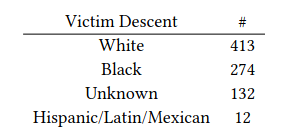

Να υλοποιηθεί το Query 4 χρησιμοποιώντας το DataFrame ή SQL API. Να εκτελέσετε την υλοποίησή σας εφαρμόζοντας κλιμάκωση στο σύνολο των υπολογιστικών πόρων που θα χρησιμοποιήσετε: Συγκεκριμένα, καλείστε να εκτελέστε την υλοποίησή σας σε 2 executors με τα ακόλουθα configurations:
- 1 core/2 GB memory
- 2 cores/4GB memory
- 4 cores/8GB memory

In [ ]:
%%configure -f
{
    "conf": {
        "spark.executor.instances": "2",
        "spark.executor.memory": "8g",
        "spark.executor.cores": "4",
        "spark.driver.memory": "2g"
    }
}

In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 4 execution") \
    .getOrCreate()

# Access configuration
conf = spark.sparkContext.getConf()

# Print relevant executor settings
# print("Executor Instances:", conf.get("spark.executor.instances"))
print("Executor Cores:", conf.get("spark.executor.cores"))
print("Executor Memory:", conf.get("spark.executor.memory"))


In [ ]:
from sedona.spark import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 4 execution") \
    .getOrCreate()

# Create sedona context
sedona = SedonaContext.create(spark)

start_time = time.time()

# Read  the Crime Data
crime_data = spark.read.parquet("s3://groups-bucket-dblab-905418150721/group43/query_2_crime_data.parquet")

# Prepare Crime Data
crime_data = crime_data.withColumn("Year", year(to_date(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a")))
crime_data = crime_data.withColumnRenamed("AREA ", "AREA") .withColumnRenamed("AREA NAME", "AREA_NAME") 


crime_data = crime_data.filter(
    (col("Year") == 2015)
)


# crime_data = crime_data.filter((col("Status") != "IC") & (col("Status") != "UNK"))

# Add geometry columns for crimes (longitude, latitude)
crimes_df = crime_data.withColumn("point", ST_Point(col("LON").cast("double"), col("LAT").cast("double")))

# Read the file from s3
geojson_path = "s3://initial-notebook-data-bucket-dblab-905418150721/2010_Census_Blocks.geojson"
blocks_df = sedona.read.format("geojson") \
            .option("multiLine", "true").load(geojson_path) \
            .selectExpr("explode(features) as features") \
            .select("features.*")
# Formatting magic
flattened_df = blocks_df.select( \
                [col(f"properties.{col_name}").alias(col_name) for col_name in \
                blocks_df.schema["properties"].dataType.fieldNames()] + ["geometry"]) \
            .drop("properties") \
            .drop("type")


#Filter out Areas outside the city of Los Angeles
flattened_df = flattened_df.filter(col("CITY") == "Los Angeles")

LA_areas = flattened_df.groupBy("COMM") \
                .agg(ST_Union_Aggr("geometry").alias("geometry"))

spatial_join_df = LA_areas.join(crimes_df, ST_Contains(col("geometry"), col("point")), "inner") \
                .filter(col("COMM").isin("Pacific Palisades", "Palisades Highlands", "Marina Peninsula"))

result_high = spatial_join_df.groupBy("Vict Descent").count().filter(col("Vict Descent").isNotNull())



spatial_join_df_low = LA_areas.join(crimes_df, ST_Contains(col("geometry"), col("point")), "inner") \
                .filter(col("COMM").isin("Rancho Park", "Encino", "Sherman Oaks"))

result_low = spatial_join_df_low.groupBy("Vict Descent").count().filter(col("Vict Descent").isNotNull())



# Read the RE_codes.csv file into a DataFrame
re_codes_path = "s3://initial-notebook-data-bucket-dblab-905418150721/RE_codes.csv"
re_codes_df = spark.read.option("header", "true").csv(re_codes_path)


# Join the result DataFrame with the RE_codes DataFrame
result_with_desc_high = re_codes_df.join(result_high, on="Vict Descent", how="left") \
                    .orderBy(desc("count")) \
                    .drop("Vict Descent")

result_with_desc_low = re_codes_df.join(result_low, on="Vict Descent", how="left") \
                    .orderBy(desc("count")) \
                    .drop("Vict Descent")

# Show the result with descriptions
print("Richest 3 Areas")
result_with_desc_high.show(3)
print("Poorest 3 Areas")
result_with_desc_low.show(3)


# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

## Query 5
Nα υπολογιστεί, ανά αστυνομικό τμήμα, ο αριθμός εγκλημάτων που έλαβαν χώρα πλησιέστερα σε αυτό, καθώς και η μέση απόστασή του από τις τοποθεσίες όπου σημειώθηκαν τα συγκεκριμένα περιστατικά. Τα αποτελέσματα να εμφανιστούν ταξινομημένα κατά αριθμό περιστατικών, με φθίνουσα
σειρά (δείτε παράδειγμα στον Πίνακα 4).

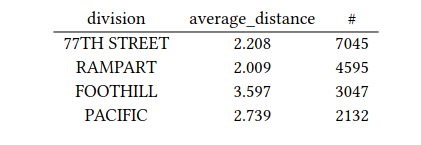

Να υλοποιηθεί το Query 5 χρησιμοποιώντας το DataFrame ή SQL API. Να εκτελέσετε την υλοποίησή σας χρησιμοποιώντας συνολικούς πόρους 8 cores και 16GB μνήμης με τα παρακάτω
configurations:
- 2 executors × 4 cores/8GB memory
- 4 executors × 2 cores/4GB memory
- 8 executors × 1 core/2 GB memory

In [ ]:
%%configure -f
{
    "conf": {
        "spark.executor.instances": "8",
        "spark.executor.cores": "1",
        "spark.executor.memory": "2g",
        "spark.driver.memory": "2g"
    }
}

In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 5 execution") \
    .getOrCreate()

# Access configuration
conf = spark.sparkContext.getConf()

# Print relevant executor settings
print("Executor Instances:", conf.get("spark.executor.instances"))
print("Executor Cores:", conf.get("spark.executor.cores"))
print("Executor Memory:", conf.get("spark.executor.memory"))


In [ ]:
from sedona.spark import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime
import time


# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("Query 5 execution") \
    .getOrCreate()

# Create sedona context
sedona = SedonaContext.create(spark)

start_time = time.time()

# Read  the Crime Data
crime_data = spark.read.parquet("s3://groups-bucket-dblab-905418150721/group43/query_2_crime_data.parquet")

# Prepare Crime Data
crime_data = crime_data.withColumn("Year", year(to_date(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a")))
crime_data = crime_data.withColumnRenamed("AREA ", "AREA") .withColumnRenamed("AREA NAME", "AREA_NAME") 

crime_data = crime_data.filter((col("LON") != 0) & (col("LAT") != 0))

print(crime_data.count())

# Add geometry columns for crimes (longitude, latitude)
crimes_df = crime_data.withColumn("crime_point", ST_Point(col("LON").cast("double"), col("LAT").cast("double")))

# Read police station data
police_stations_path = "s3://initial-notebook-data-bucket-dblab-905418150721/LA_Police_Stations.csv"
police_stations_df = spark.read.option("header", "true").csv(police_stations_path)

# Add geometry columns for police stations (X, Y coordinates)
police_stations_df = police_stations_df.withColumn("station_point", ST_Point(col("X").cast("double"), col("Y").cast("double")))

# Perform a cross join to compute distances
crime_with_station_distances = crimes_df.crossJoin(police_stations_df) \
    .withColumn("distance", ST_DistanceSphere(col("crime_point"), col("station_point"))/1000)

# Define a window partitioned by DR_NO and ordered by distance
window = Window.partitionBy("DR_NO").orderBy("distance")

# Keep pairs with minimum distance
df_with_min_distance = crime_with_station_distances.withColumn("min_distance", min("distance").over(window))

df_crime_dep_min_dist = df_with_min_distance.filter(col("distance") == col("min_distance"))

df_dep_avg_dist = df_crime_dep_min_dist.groupBy("DIVISION").agg(
    avg("distance").alias("average distance"),
    count("DR_NO").alias("#")
)



# Show the result
df_dep_avg_dist.orderBy(desc("#")).show(df_dep_avg_dist.count())



# Stop timing and print out the execution duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")